<a href="https://colab.research.google.com/github/renatavel/goit_ds_homeworks/blob/main/hw_11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Створення нейронної мережі

У цьому завданні ми створимо повнозв'язну нейронну мережу, використовуючи при цьому низькорівневі механізми tensorflow.

Архітектура нейромережі представлена на наступному малюнку. Як бачиш, у ній є один вхідний шар, два приховані, а також вихідний шар. В якості активаційної функції у прихованих шарах буде використовуватись сигмоїда. На вихідному шарі ми використовуємо softmax.

Частина коду зі створення мережі вже написана, тобі потрібно заповнити пропуски у вказаних місцях.

## Архітектура нейронної мережі

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## Про датасет MNIST

Дану нейромережу ми будемо вивчати на датасеті MNIST. Цей датасет являє собою велику кількість зображень рукописних цифр розміром $28 \times 28$ пікселів. Кожен піксель приймає значення від 0 до 255.

Як і раніше, датасет буде розділений на навчальну та тестову вибірки. При цьому ми виконаємо нормалізацію всіх зображень, щоб значення пікселів знаходилось у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.

Окрім того, архітектура нейронної мережі очікує на вхід вектор. У нашому ж випадку кожен об'єкт вибірки являє собою матрицю. Що ж робити? У цьому завданні ми "розтягнемо" матрицю $28 \times 28$, отримавши при цьому вектор, що складається з 784 елементів.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Більше інформації про датасет можна знайти [тут](http://yann.lecun.com/exdb/mnist/).

In [188]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras as K
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [189]:
num_classes = 10 # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784 # кількість атрибутів вхідного вектора 28 * 28 = 784

learning_rate = 0.001 # швидкість навчання нейронної мережі
training_steps = 3000 # максимальне число епох
batch_size = 256 # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів
display_step = 100 # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат і точності

n_hidden_1 = 128 # кількість нейронів 1-го шару
n_hidden_2 = 256 # кількість нейронів 2-го шару

In [190]:
# from tensorflow.keras.datasets import mnist
from tensorflow.keras.datasets import mnist

# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Перетворюємо матриці розміром 28x28 пікселів у вектор з 784 елементів
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.

# Перемішаємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [191]:
# Створимо нейронну мережу

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation != 0:
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)

class NN(tf.Module):
  def __init__(self, name=None):
      super().__init__(name=name)
      # Перший шар, який складається з 128 нейронів
      self.layer1 = DenseLayer(in_features=num_features, out_features=n_hidden_1)
      # Другий шар, який складається з 256 нейронів
      self.layer2 = DenseLayer(in_features=n_hidden_1, out_features=n_hidden_2)
      # Вихідний шар
      self.output_layer = DenseLayer(in_features=n_hidden_2, out_features=num_classes)


  def __call__(self, x):
      # Передача даних через перші два шари та вихідний шар з функцією активації softmax
      x1 = self.layer1(x, activation=0)
      x2 = self.layer2(x1, activation=0)
      x3 = self.output_layer(x2, activation=1)
      return x3

In [192]:
# В якості функції помилки в даному випадку зручно взяти крос-ентропію
def cross_entropy(y_pred, y_true):
    # Закодувати label в one hot vector
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Значення передбачення, щоб уникнути помилки log(0).
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Обчислення крос-ентропії
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# Як метрику якості використовуємо точність
def accuracy(y_pred, y_true):
    acc = tf.metrics.Accuracy()
    acc.update_state(y_true, tf.argmax(y_pred, axis=1))
    return acc.result()

In [193]:
# Створимо екземпляр нейронної мережі
neural_net = NN(name="mnist")

# Функція навчання нейромережі
def train(neural_net, input_x, output_y):
  # Для налаштування вагів мережі будемо використовувати стохастичний градієнтний спуск
  optimizer = tf.optimizers.SGD(learning_rate)

  # Активація автоматичного диференціювання
  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)

    # Отримаємо список оптимізованих параметрів
    trainable_variables = neural_net.trainable_variables
    # Обчислимо за ними значення градієнта
    gradients = g.gradient(loss, trainable_variables)

    # Модифікуємо параметри
    optimizer.apply_gradients(zip(gradients, trainable_variables))
    return loss

In [194]:
# Тренування мережі

loss_history = []  # кожні display_step кроків зберігай в цьому списку поточну помилку нейромережі
accuracy_history = [] # кожні display_step кроків зберігай в цьому списку поточну точність нейромережі

# У цьому циклі ми будемо проводити навчання нейронної мережі
# із тренувального датасета train_data вилучи випадкову підмножину, на якій
# відбудеться тренування. Використовуй метод take, доступний для тренувального датасета.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Оновлюємо ваги нейронної мережі
    train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
        pred = neural_net(batch_x)
        loss = cross_entropy(pred, batch_y)
        loss_history.append(loss)

        acc = accuracy(pred, batch_y)
        accuracy_history.append(acc)
        print(f"Step {step}: loss = {loss}, accuracy = {acc}")


Step 100: loss = 355.21270751953125, accuracy = 0.66796875
Step 200: loss = 207.69219970703125, accuracy = 0.78515625
Step 300: loss = 188.92498779296875, accuracy = 0.79296875
Step 400: loss = 198.3838653564453, accuracy = 0.76953125
Step 500: loss = 128.76242065429688, accuracy = 0.83984375
Step 600: loss = 164.98411560058594, accuracy = 0.8203125
Step 700: loss = 131.31053161621094, accuracy = 0.84765625
Step 800: loss = 118.34786224365234, accuracy = 0.87109375
Step 900: loss = 117.96806335449219, accuracy = 0.8671875
Step 1000: loss = 110.41154479980469, accuracy = 0.875
Step 1100: loss = 119.38955688476562, accuracy = 0.86328125
Step 1200: loss = 110.21415710449219, accuracy = 0.87890625
Step 1300: loss = 133.81430053710938, accuracy = 0.88671875
Step 1400: loss = 93.63422393798828, accuracy = 0.90625
Step 1500: loss = 93.8865966796875, accuracy = 0.859375
Step 1600: loss = 121.7625961303711, accuracy = 0.8828125
Step 1700: loss = 85.28242492675781, accuracy = 0.8984375
Step 1800

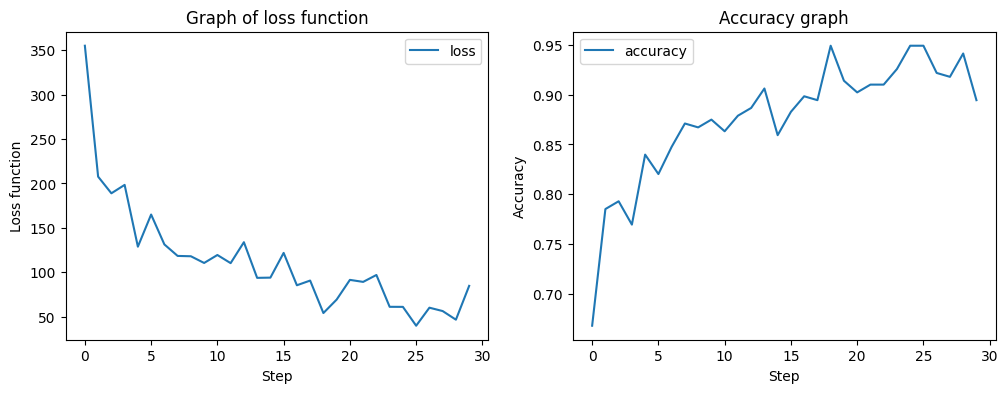

In [195]:
# Виведіть графіки залежності зміни точності і втрат від кроку
# Якщо все зроблено правильно, то точність повинна зростати, а втрати зменшуватись

import matplotlib.pyplot as plt

# Виведіть графік функції втрат
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(loss_history, label='loss')
plt.title('Graph of loss function')
plt.xlabel('Step')
plt.ylabel('Loss function')
plt.legend()

# Виведіть графік точності
plt.subplot(1, 2, 2)
plt.plot(accuracy_history, label='accuracy')
plt.title('Accuracy graph')
plt.xlabel('Step')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [196]:
from sklearn.metrics import classification_report

model_accuracy = accuracy(neural_net(x_train), y_train)
print(f"Accuracy: {model_accuracy}")

Accuracy: 0.9193500280380249


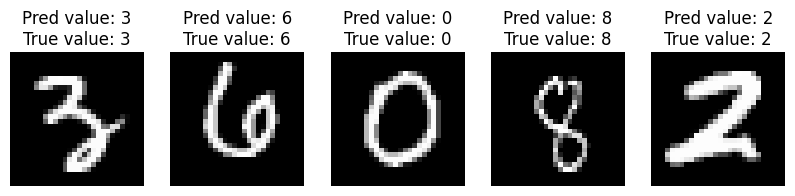

Errors: 0 out of 5 images.
Accuracy score on the selected images: 100.00%


In [197]:
# Протестуйте навчену нейромережу на 10 зображеннях. З тестової вибірки візьміть 5
# випадкових зображень і передайте їх у нейронну мережу.
# Виведіть зображення та випишіть  поруч відповідь нейромережі.
# Зробіть висновок про те, чи помиляється твоя нейронна мережа, і якщо так, то як часто?

def plot_images(images, predictions, true_labels):
    plt.figure(figsize=(10, 10))
    for i in range(5):
        plt.subplot(1, 5, i+1)
        plt.imshow(images[i].reshape(28, 28), cmap='gray')
        plt.title(f"Pred value: {predictions[i]}\nTrue value: {true_labels[i]}")
        plt.axis('off')
    plt.show()

def test_random_images(neural_net, x_test, y_test, num_images=5):
    random_indices = np.random.choice(len(x_test), num_images, replace=False)
    random_images = x_test[random_indices]
    random_labels = y_test[random_indices]

    predictions = np.argmax(neural_net(random_images), axis=1)
    plot_images(random_images, predictions, random_labels)

    errors = np.sum(predictions != random_labels)
    print(f"Errors: {errors} out of {num_images} images.")
    accuracy = (num_images - errors) / num_images
    print(f"Accuracy score on the selected images: {accuracy * 100:.2f}%")

# Тестуємо на випадкових зображеннях
test_random_images(neural_net, x_test, y_test)
